# GSMM mixture modelling with synthetic data

## Import packages and functions

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using Clustering

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/complex_gaussian.jl")
include("../extensions/hgf.jl")
include("../functions/auxiliary/workflow.jl")


em (generic function with 1 method)

## Generate data

In [3]:
# generate data
import Distributions: Normal, MvNormal, MixtureModel, Dirichlet
nr_samples = 200
nr_freqs = 5

# simulate 2 clusters
μ_ξi1 = 1.0*collect(1:1:1*nr_freqs)
μ_ξi2 = 1.0*collect(2:2:2*nr_freqs)
Σ_ξ = 1e-4*diagm(ones(nr_freqs))
Σ_meas = 1e-10*diagm(ones(nr_freqs))

# create arrays for samples
cluster_id = Array{Int64,1}(undef, nr_samples)
ξ_samples = Array{Array{Float64,1},1}(undef, nr_samples)
X_samples = Array{Array{Complex{Float64},1},1}(undef, nr_samples)
y_samples = Array{Array{Complex{Float64},1},1}(undef, nr_samples)

for n = 1:nr_samples
     
    # create arrays for frequencies
    ξ_samples[n] = Array{Float64,1}(undef, nr_freqs)
    X_samples[n] = Array{Complex{Float64},1}(undef, nr_freqs)
    y_samples[n] = Array{Complex{Float64},1}(undef, nr_freqs)
    
    # randomly pick cluster to get means from 
    cluster_id[n] = rand([1,2,2])
    if cluster_id[n] == 1
        μ_ξi = μ_ξi1
    else
        μ_ξi = μ_ξi2
    end
    
    for k = 1:nr_freqs
        sample_ξ = rand(Normal(μ_ξi[k], sqrt(Σ_ξ[k,k])))
        sample_X = rand(Normal(0, sqrt(0.5*exp(sample_ξ)))) + 1im*rand(Normal(0, sqrt(0.5*exp(sample_ξ))))
        sample_y = rand(Normal(real(sample_X), sqrt(0.5*Σ_meas[k,k]))) + 1im*rand(Normal(imag(sample_X), sqrt(0.5*Σ_meas[k,k])))

        ξ_samples[n][k] = sample_ξ
        X_samples[n][k] = sample_X
        y_samples[n][k] = sample_y
    end
end

t = collect(1:nr_samples)
Y = y_samples;

# Building graph

In [4]:
# initialization:

# reshape Y
Yi = hcat(Y...)

# approximate with log-power
Yi = log.(abs2.(Yi))

# perform kmeans clustering
prior_m = kmeans(Yi,2).centers

5×2 Array{Float64,2}:
 0.601493  1.35616
 1.56028   3.40423
 2.47426   5.55853
 3.47362   7.41512
 4.5188    9.40689

In [5]:
#nr_freqs = dimension

nr_clusters = 2

fg = FactorGraph()
α = 1
# Specify generative model
@RV _pi ~ ForneyLab.Beta(α, α)
@RV w_1 ~ Wishart(diagm(ones(nr_freqs)), nr_freqs+2)
@RV m_1 ~ GaussianMeanPrecision(prior_m[:,1], w_1)
@RV w_2 ~ Wishart(diagm(ones(nr_freqs)), nr_freqs+2)
@RV m_2 ~ GaussianMeanPrecision(prior_m[:,2], w_2)

z = Vector{Variable}(undef, nr_samples)
ξ = Vector{Variable}(undef, nr_samples)
X = Vector{Variable}(undef, nr_samples)
y = Vector{Variable}(undef, nr_samples)
for i in 1:nr_samples
    @RV z[i] ~ Bernoulli(_pi)
    @RV ξ[i] ~ GaussianMixture(z[i], m_1, w_1, m_2, w_2)
    # HGF
    @RV X[i] ~ HGF(ξ[i])

    # observation model
    @RV y[i] ~ ComplexNormal(X[i], 1e-10*diagm(ones(nr_freqs)).+0im, mat(0.0+0.0im))
    
    
    placeholder(y[i], :y, index=i, dims=(nr_freqs,))
end
# draw graph
# ForneyLab.draw(fg)

In [6]:
# Build the algorithm
q = PosteriorFactorization(_pi, m_1, w_1, m_2, w_2, z, X, ξ, ids=[:PI :M1 :W1 :M2 :W2 :Z :X :Ξ])
algo = variationalAlgorithm(q)

# Generate source code
source_code = algorithmSourceCode(algo);

# Load algorithm
eval(Meta.parse(source_code));

In [7]:
data = Dict(:y => Y)

# Prepare posterior factors
marginals = Dict(:_pi => vague(ForneyLab.Beta),
                 :m_1 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=prior_m[:,1], w=1e0*diagm(ones(nr_freqs))),
                 :w_1 => ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=1e0*diagm(ones(nr_freqs)), nu=nr_freqs),
                 :m_2 => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=prior_m[:,2], w=1e0*diagm(ones(nr_freqs))),
                 :w_2 => ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=1e0*diagm(ones(nr_freqs)), nu=nr_freqs))
for i in 1:nr_samples
    marginals[:z_*i] = vague(Bernoulli)
    marginals[:X_*i] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e-10*diagm(ones(nr_freqs)).+0im, C=mat(0.0+0.0im));
    marginals[:ξ_*i] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=zeros(nr_freqs), v=diagm(ones(nr_freqs)))
end



In [8]:
# Execute algorithm
nr_its = 10
@showprogress for i in 1:nr_its
    stepX!(data, marginals)
    stepΞ!(data, marginals)
    stepZ!(data, marginals)
    stepPI!(data, marginals)
    stepM1!(data, marginals)
    stepW1!(data, marginals)
    stepM2!(data, marginals)
    stepW2!(data, marginals)  
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:07TA: 0:01:42


In [9]:
marginals[:_pi]

Beta(a=73.00, b=1.29e+02)


In [10]:
# these are the means as determined by the k-means algorithm
prior_m

5×2 Array{Float64,2}:
 0.601493  1.35616
 1.56028   3.40423
 2.47426   5.55853
 3.47362   7.41512
 4.5188    9.40689

In [11]:
# Ideally 1:5 or 2:2:10 (depending on cluster assignment, fixed offset of HGF is present)
ForneyLab.unsafeMean(marginals[:m_1])

5-element Array{Float64,1}:
 0.6444885996907452
 1.542159808524552 
 2.4189260770136363
 3.4820824644918966
 4.601710222498747 

In [12]:
# Ideally 1:5 or 2:2:10 (depending on cluster assignment, fixed offset of HGF is present)
ForneyLab.unsafeMean(marginals[:m_2])

5-element Array{Float64,1}:
 1.3072993489529658
 3.351015483328147 
 5.420812984477029 
 7.281519839722426 
 9.259465467831184 

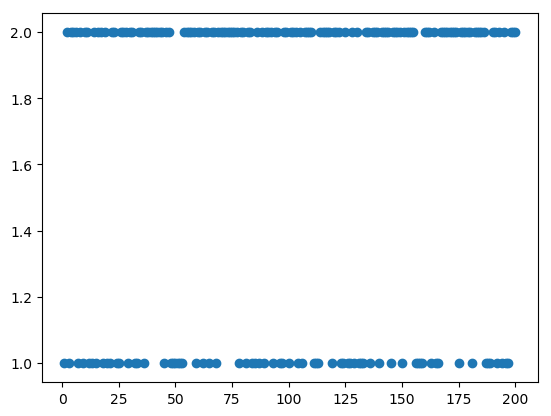

PyObject <matplotlib.collections.PathCollection object at 0x0000000002252E80>

In [13]:
# scatter plot of true cluster assignemtns
plt.scatter(t,cluster_id)

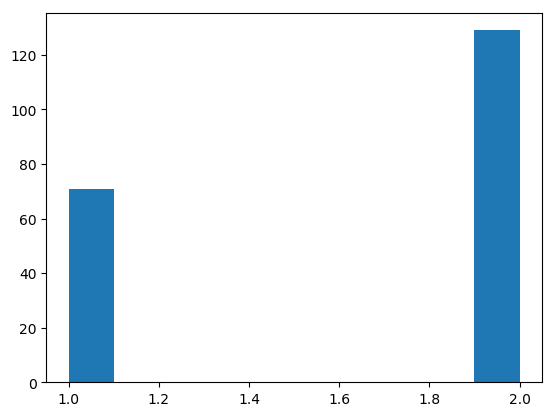

([71.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 129.0], [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7000000000000002, 1.8, 1.9, 2.0], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x00000000022F3BA8>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022F3978>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022FD1D0>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022FD518>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022FD860>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022FDBA8>, PyObject <matplotlib.patches.Rectangle object at 0x00000000022FDEF0>, PyObject <matplotlib.patches.Rectangle object at 0x000000000230A278>, PyObject <matplotlib.patches.Rectangle object at 0x000000000230A5C0>, PyObject <matplotlib.patches.Rectangle object at 0x000000000230A908>])

In [14]:
# histogram of cluster assignments
plt.hist(cluster_id)

In [19]:
# inferred cluster assignments
z_inferred = [Int(round(marginals[:z_*k].params[:p])) for k = 1:nr_samples];

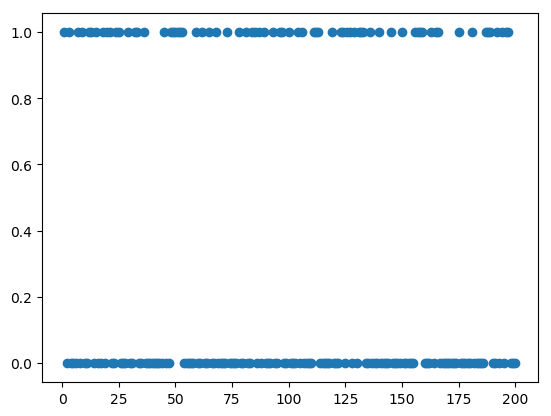

PyObject <matplotlib.collections.PathCollection object at 0x0000000002617470>

In [20]:
# scatter plot of inferred cluster assignments
plt.scatter(t,z_inferred)

In [25]:
function confusmat(k::Integer, gts::Array{Int64,1}, preds::Array{Int64,1})
    # borrowed from MLBase
    n = length(gts)
    length(preds) == n || throw(DimensionMismatch("Inconsistent lengths."))
    R = zeros(Int, k, k)
    for i = 1:n
        @inbounds g = gts[i]
        @inbounds p = preds[i]
        R[g, p] += 1
    end
    return R
end

confusmat(nr_clusters, cluster_id .- minimum(cluster_id) .+ 1, z_inferred .- minimum(z_inferred) .+ 1)

2×2 Array{Int64,2}:
   0  71
 128   1